In [13]:
import os
import music21 as m21
import json
import keras
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # cuz my version of python complains about deprecated stuff

In [14]:
songs_path = "songs"
acceptable_durations = [0.25, 0.5, 0.75, 1.0, 1.5, 2, 3, 4]
preprocessing_path = "preprocessing"
single_file_path = "input"
mapping_path = "mapping.json"
sequence_length = 64

### Preprocessing

Using the "Generating Melodies with a Neural Network" series by Valerio Velardo on youtube, I took inspiration for preprocessing. He uses a German folksong dataset, and I used the Kaggle Lofi dataset.
I tried:
- filtering out songs with notes with weird durations (so it doesn't do insanely short or insanely long notes)
- transposing all training data to C major or A minor (cuz all songs are in some major/minor key signature, but I figured this would kinda standardize the data so that anything produced would remain in the appropriate key and not sound so off-putting)
- mapping individual notes AND chords to individual entries so that it plays chords as likely next notes as well

In [15]:
def load_songs(folder_path):
    songs = []

    for file in os.listdir(folder_path):
        song = m21.converter.parse(os.path.join(folder_path, file))
        songs.append(song)

    return songs

def has_acceptable_notes(song, acceptable_durations):
    for note in song.flatten().notesAndRests: # filters out metadata from the m21 stuff so it's just the notes
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True
        
def transpose(song):
    key = song.analyze('key')

    if key.mode == 'major':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('C'))
    elif key.mode == 'minor':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('A'))

    transposed_song = song.transpose(interval)
    return transposed_song

def encode_song(song, time_step = 0.25):

    encoded_song = []

    for note in song.flatten().notesAndRests:
        if isinstance(note, m21.note.Note):
            symbol = f"{note.pitch.midi}"
        elif isinstance(note, m21.note.Rest):
            symbol = "r"
        elif isinstance(note, m21.chord.Chord):
            symbol = ".".join(str(n.midi) for n in note.pitches)
        
        steps = int(note.duration.quarterLength / time_step)

        for step in range(steps):
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    encoded_song = " ".join(map(str, encoded_song))
    return encoded_song

def load(path):
    with open(path, "r") as f:
        song = f.read()
    return song

def condense(dataset_path, file_dataset_path):
    delimiter = "/ " # to signify the end of a song
    songs = ""

    for file in os.listdir(dataset_path):
        path = os.path.join(dataset_path, file)
        song = load(path)
        songs += song + " " + delimiter
    songs = songs[:-1] # gets rid of the final delimiter

    with open(file_dataset_path, "w") as f:
        f.write(songs)

    return songs


def preprocess(folder_path):
    print("Loading songs...")
    songs = load_songs(folder_path)
    print(f"Loaded {len(songs)} songs.\n")
    
    for i, song in enumerate(songs):
        if not has_acceptable_notes(song, acceptable_durations):
            continue

        transposed_song = transpose(song)

        encoded_song = encode_song(transposed_song)

        save_path = os.path.join(preprocessing_path, str(i))
        with open(save_path + ".txt", "w") as f:
            f.write(encoded_song)

        

In [16]:
preprocess(songs_path)
songs = condense(preprocessing_path, single_file_path)

Loading songs...
Loaded 93 songs.



Mapping to Readable Notation

In [17]:
def create_mapping(songs, mapping_path):
    mappings = {}

    songs = songs.split()
    vocab = sorted(set(songs)) # keeps unique symbols in order

    for i, symbol in enumerate(vocab): # isolates unique symbols
        mappings[symbol] = i

    with open(mapping_path, "w") as f:
        json.dump(mappings, f, indent=4)

def convert_to_int(songs):
    int_songs = []

    with open(mapping_path, "r") as f:
        mappings = json.load(f)
    songs = songs.split()

    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs

def generate_batches(sequence_length):
    songs = load(single_file_path)
    int_songs = convert_to_int(songs)

    inputs = []
    targets = []
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i + sequence_length]) # slides time series by one step
        targets.append(int_songs[i + sequence_length])

    vocab_size = len(set(int_songs))
    inputs = keras.utils.to_categorical(inputs, num_classes=vocab_size)
    targets = np.array(targets)

    return inputs, targets

In [18]:
create_mapping(songs, mapping_path)
inputs, targets = generate_batches(sequence_length=64)

### Model 1, using LSTM cells

In [19]:
vocab_size = 126
model1 = keras.Sequential()
model1.add(keras.Input(shape=(None, vocab_size)))
model1.add(keras.layers.LSTM(128))
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.Dense(vocab_size, activation='softmax'))

model1.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Nadam(), metrics=["accuracy"])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       130,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 126)            │        16,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,814 (573.49 KB)

 Trainable params: 146,814 (573.49 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model1.fit(inputs, targets, epochs=60, batch_size=64)
model1.save("model1.h5")

Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6615 - loss: 2.7050
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7144 - loss: 1.6644
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7149 - loss: 1.6590
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7149 - loss: 1.6386
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7149 - loss: 1.6322
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7149 - loss: 1.6182
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7149 - loss: 1.5818
Epoch 8/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7149 - loss: 1.5645
Epoch 9/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7188 - loss: 1.5436
Epoch 10/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7177 - loss: 1.5506
Epoch 11/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7205 - loss: 1.5254
Epoch 12/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy:

In [21]:
generator = keras.models.load_model("model1.h5")
mappings = json.load(open(mapping_path, "r"))

In [22]:
def generate(model, mappings, sequence_length, seed, num_steps=500, temperature=1.0):
    reverse_mapping = {v: k for k, v in mappings.items()}
    vocab_size = len(mappings)

    seed_int = [mappings[symbol] for symbol in seed.split()]
    output = list(seed_int)

    for _ in range(num_steps):
        seed_sequence = output[-sequence_length:]
        onehot = keras.utils.to_categorical(seed_sequence, num_classes=vocab_size)
        onehot = np.expand_dims(onehot, axis=0)

        preds = model.predict(onehot, verbose=0)[0]

        preds = np.log(preds + 1e-8) / temperature
        preds = np.exp(preds) / np.sum(np.exp(preds))

        next_idx = np.random.choice(range(vocab_size), p=preds)
        output.append(next_idx)

    generated = [reverse_mapping[i] for i in output]
    return " ".join(generated)

def decode_song(encoded_song, time_step=0.25, file_name="generated_song"):

    song_stream = m21.stream.Stream()
    symbols = encoded_song.split()
    step_counter = 0
    prev_symbol = None

    for symbol in symbols:
        if symbol != "_":
            if prev_symbol and step_counter > 0:
                dur = m21.duration.Duration(step_counter * time_step)
                song_stream[-1].duration = dur
            if symbol == "r" or symbol == "/":
                song_stream.append(m21.note.Rest())
            elif "." in symbol:
                pitches = [int(x) for x in symbol.split(".")]
                song_stream.append(m21.chord.Chord(pitches))
            else:
                midi_number = int(symbol)
                song_stream.append(m21.note.Note(midi_number))
            step_counter = 1
            prev_symbol = symbol
        else:
            step_counter += 1

    song_stream.write("midi", fp=f"{file_name}.mid")
    return song_stream

In [23]:
seed = "52.55.72 _ _ _ _ _ 69 _ _ _ _ _ 60.76 _ _ _ _ _ _ 69 _ _ _ _" # so each has the same starting notes
generated = generate(model1, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=0.8)
model1_low = decode_song(generated, time_step=0.25, file_name="model1_low_temp")

generated = generate(model1, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=2)
model1_high = decode_song(generated, time_step=0.25, file_name="model1_high_temp")

### Model 2, using trainable embeddings
This needs modifying the batches

In [24]:
def generate_batches(sequence_length):
    songs = load(single_file_path)
    int_songs = convert_to_int(songs)

    inputs = []
    targets = []
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i + sequence_length])
        targets.append(int_songs[i + sequence_length])

    vocab_size = len(set(int_songs))

    inputs = np.array(inputs) 
    targets = np.array(targets)

    return inputs, targets, vocab_size

inputs, targets, vocab_size = generate_batches(sequence_length=64)

In [25]:
embedding_dim = 64

model2 = keras.Sequential()
model2.add(keras.Input(shape=(sequence_length,)))
model2.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model2.add(keras.layers.LSTM(128))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(vocab_size, activation='softmax'))

model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Nadam(), metrics=["accuracy"])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 64, 64)         │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 126)            │        16,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,134 (480.99 KB)

 Trainable params: 123,134 (480.99 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model2.fit(inputs, targets, epochs=60, batch_size=64)
model2.save("model2.h5")
generator = keras.models.load_model("model2.h5")

Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6899 - loss: 2.4187
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7149 - loss: 1.6320
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7160 - loss: 1.5710
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7205 - loss: 1.5209
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7238 - loss: 1.4767
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7339 - loss: 1.4413
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7311 - loss: 1.4190
Epoch 8/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7478 - loss: 1.3842
Epoch 9/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7533 - loss: 1.3663
Epoch 10/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7550 - loss: 1.3511
Epoch 11/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7545 - loss: 1.3450
Epoch 12/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy:

In [27]:
def generate_with_embeddings(model, mappings, sequence_length, seed, num_steps=500, temperature=1.0):
    reverse_mapping = {v: k for k, v in mappings.items()}
    vocab_size = len(mappings)

    seed_int = [mappings[symbol] for symbol in seed.split()]
    output = list(seed_int)

    for _ in range(num_steps):
        seed_sequence = output[-sequence_length:] # now one-hot encoding is not needed
        seed_sequence = np.array([seed_sequence])

        preds = model.predict(seed_sequence, verbose=0)[0]

        preds = np.log(preds + 1e-8) / temperature
        preds = np.exp(preds) / np.sum(np.exp(preds))

        next_idx = np.random.choice(range(vocab_size), p=preds)
        output.append(next_idx)

    generated = [reverse_mapping[i] for i in output]
    return " ".join(generated)

In [33]:
generated = generate_with_embeddings(model2, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=0.8)
model2_low = decode_song(generated, time_step=0.25, file_name="model2_low_temp")

generated = generate_with_embeddings(model2, mappings, sequence_length=64, seed=seed, num_steps=200, temperature=2)
model2_high = decode_song(generated, time_step=0.25, file_name="model2_high_temp")

### Observations


- low temp cuts off just about right after the seed is done. I think this is cuz the training data typically only contains snippets that are a few chords long, so it predicts the delimiter which cuts off the song
- low temp for trainable embeddings has lots of sustained notes
- high temp for both models consistently chooses less rests in a row
- alternation between single notes and chords in both
- it loves C notes

### Diagrams

##### Model 2, high temp display

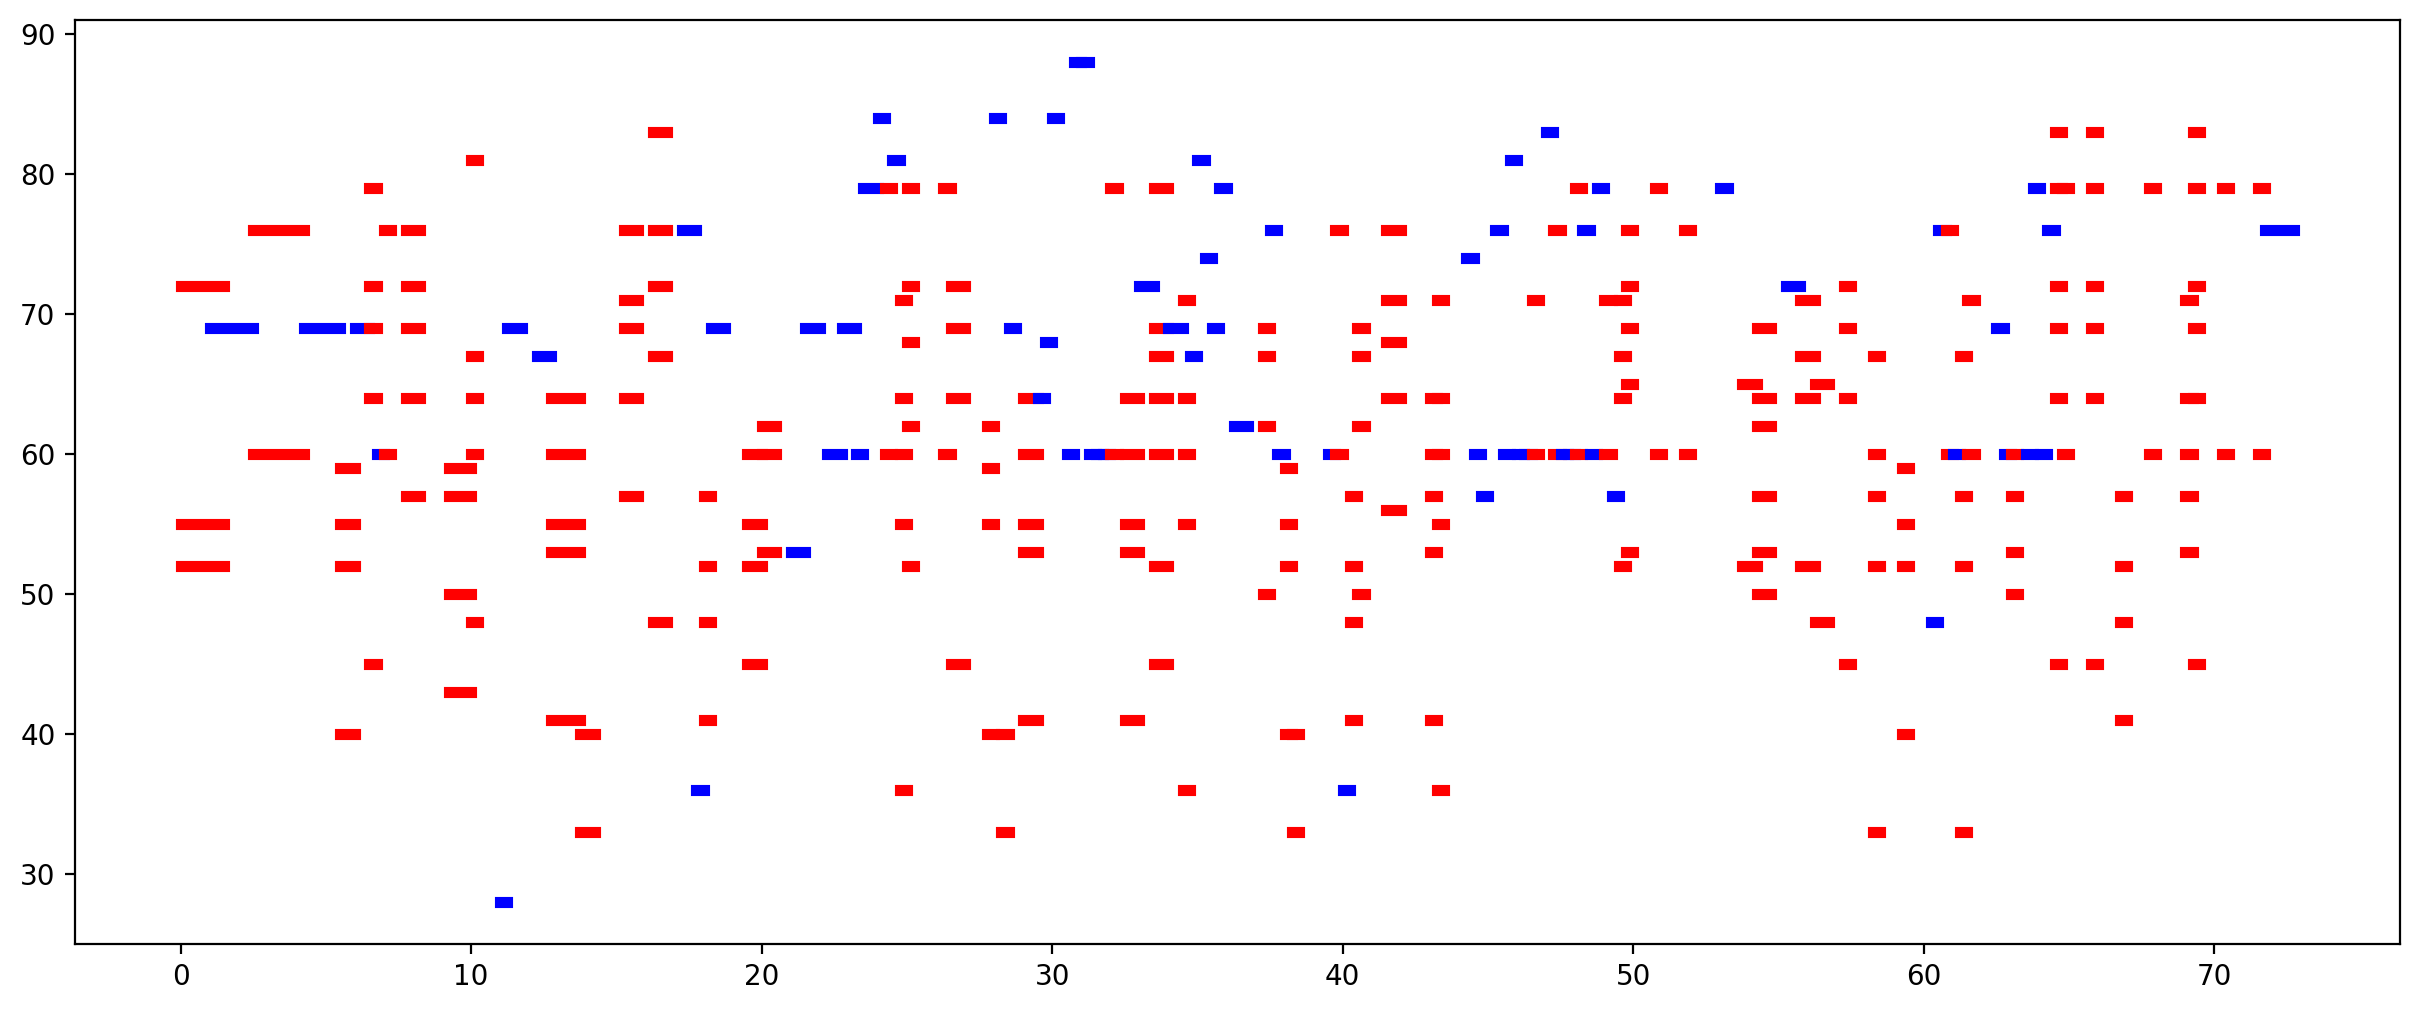

In [ ]:
def visualize_midi(song_stream):
    plt.figure(figsize=(15, 6))
    
    for element in song_stream.flatten().notesAndRests:
        if isinstance(element, m21.note.Note):
            plt.plot([element.offset, element.offset + element.duration.quarterLength], 
                    [element.pitch.midi, element.pitch.midi], 'b-', linewidth=4)
        elif isinstance(element, m21.chord.Chord):
            for pitch in element.pitches:
                plt.plot([element.offset, element.offset + element.duration.quarterLength], 
                        [pitch.midi, pitch.midi], 'r-', linewidth=4)
    plt.show()

visualize_midi(model2_high)

##### Model 2 high temp note usage count

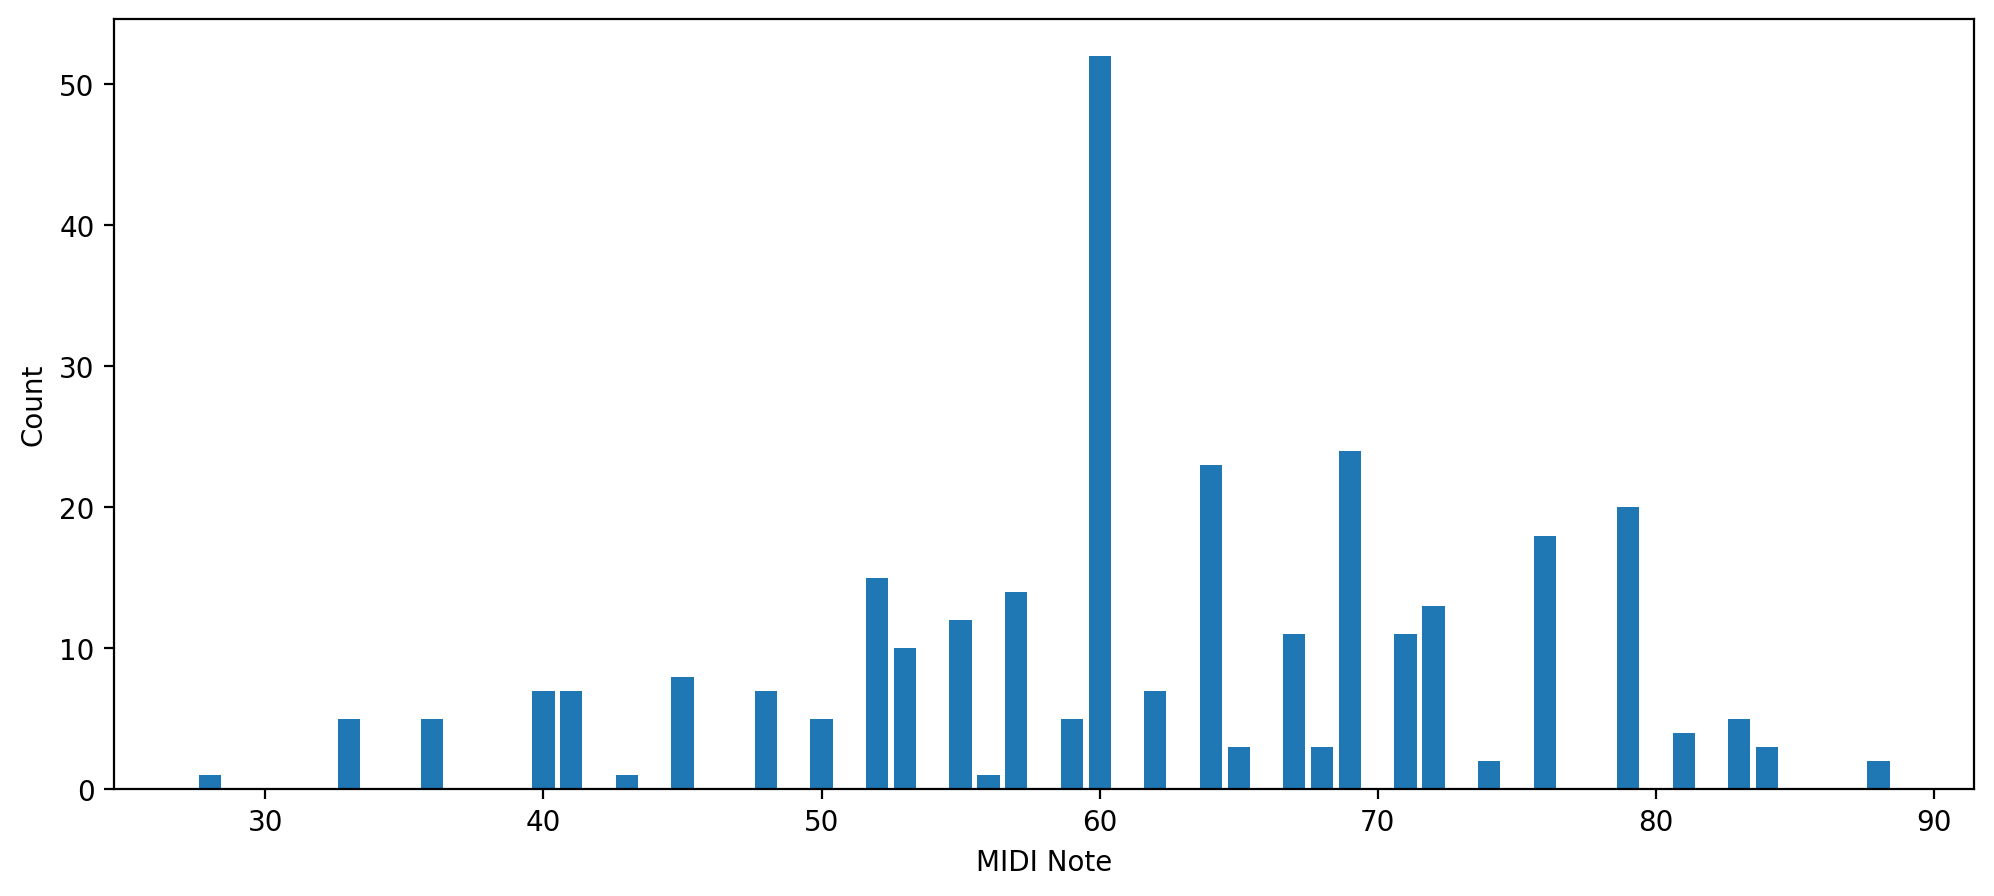

In [35]:
from collections import Counter

def plot_note_frequency(song_stream):
    notes = []
    for element in song_stream.flatten().notesAndRests:
        if isinstance(element, m21.note.Note):
            notes.append(element.pitch.midi)
        elif isinstance(element, m21.chord.Chord):
            notes.extend([p.midi for p in element.pitches])
    
    counts = Counter(notes)
    
    plt.figure(figsize=(12, 5))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('MIDI Note')
    plt.ylabel('Count')
    plt.show()

plot_note_frequency(model2_high)

for reference, midi note chart by Matthijs Hollemans:
<br/>
<img src="midi-note-chart.jpg" width="500">

60 is C, so that tracks